# Analyzing Simulated Homepage Conversion Rate A/B Test Results
## By Jessica Li

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction
For this side project, I have a synthetic dataset consisting of 294,479 observations of 50/50 split user visits to two homepage versions. The old homepage is the control group and the new homepage is the treatment group. Each visit has a binary indication of whether or not the user clicked a link and thus "converted". I am interested to understand the A/B results via hypothesis testing in two approaches--bootstrap sampling and logistics regression. P-values are generated for the A/B test to determine to what degree there was meaningful change in conversion rate for the new homepage. This project should help one better understand the steps needed to statistically determine A/B test results.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [6]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Now let's read in the `ab_data.csv` data and take a peek at the first few rows

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset

In [7]:
df.shape

(294478, 5)

Find number of unique users in the dataset

In [4]:
df.user_id.nunique()

290584

Find proportion of users converted

In [8]:
df.converted.value_counts(normalize=True)*100

0    88.034081
1    11.965919
Name: converted, dtype: float64

Now let's check the cleanliness of the dataset. Starting with finding the number of times the `new_page` and `treatment` don't line up

In [9]:
df.query('landing_page == "new_page" and group != "treatment" \
         or group == "treatment" and landing_page != "new_page"').shape[0]

3893

Look for any rows with missing values

In [10]:
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


Looks like we don't have missing values within the rows but we do have some nonsensical values. For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Let's remove those values and create a new dataframe

In [8]:
df2 = df.query('landing_page == "new_page" and group == "treatment" \
         or landing_page == "old_page" and group == "control"')

In [9]:
# Double check all the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now let's dig deeper into **user_ids**

Number of unique **user_id**s  in **df2**

In [11]:
df2.user_id.nunique()

NameError: name 'df2' is not defined

Looking for any potential duplicated **user_id**s in **df2**

In [11]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

Found one! Let's look at the row information for the repeat **user_id**

In [12]:
df2.query('user_id == 773192')

NameError: name 'df2' is not defined

Remove **one** of the rows with the duplicate **user_id**

In [13]:
df2 = df2.drop_duplicates(subset='user_id', keep="first")

NameError: name 'df2' is not defined

Now with our clean dataset, let's look more closely at the conversion rate data. There are a couple questions top of mind we can answer here.

In [15]:
df.converted.value_counts(normalize=True)*100

0    88.034081
1    11.965919
Name: converted, dtype: float64

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
convertrate_control = df2.query('group == "control"').converted.mean()
convertrate_control

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
convertrate_treatment = df2.query('group == "treatment"').converted.mean()
convertrate_treatment

0.11880806551510564

What is the probability that an individual received the new page?

In [17]:
df.landing_page.value_counts(normalize=True)*100

new_page    50.0
old_page    50.0
Name: landing_page, dtype: float64

Looking simply at conversion rate probability is insufficient evidence to say that the new treatment page leads to more conversions. The conversion rate between the control and the treatment group differs by a very small percentage, 0.15%. It is not critical enough to simply look at the absolute value difference and conclude that the one with the higher percentage leads to more conversions. Whether or not this difference in behaviour is statistically significant is important. For example, this difference could be purely due to chance. We need to do further statistical analysis to deduce if this data truly represents stronger favour for one group over the other.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, one could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider you need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the corresponding null and alternative hypotheses are:

**$H_{0}$**: **$p_{new}$** ≤ **$p_{old}$**

Null Hypothesis: The new homepage's conversion rate is less than or equal to that of the old homepage.

**$H_{1}$**: **$p_{new}$** > **$p_{old}$**

Alternative Hypothesis: The new homepage's conversion rate is higher than that of the old homepage.

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

I will now perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
convert_rate = df.converted.mean()
convert_rate

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
convert_rate = df.converted.mean()
convert_rate

0.11965919355605512

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_rate), convert_rate])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_rate), convert_rate])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean()- old_page_converted.mean()

-0.0007937758685436086

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs = []

for i in range(10000):
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_rate), convert_rate])
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_rate), convert_rate])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [30]:
# Convert p_diffs from a list to an array
p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

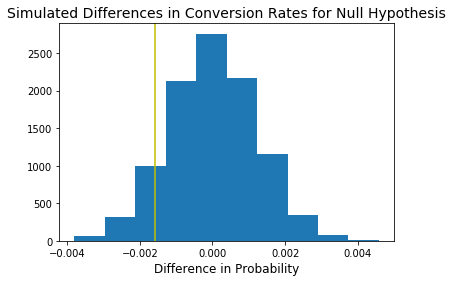

In [31]:
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis", fontsize=14)
plt.xlabel("Difference in Probability", fontsize=12)
plt.axvline(convertrate_treatment - convertrate_control, color='y');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
observed_diff = convertrate_treatment - convertrate_control

(p_diffs > observed_diff).mean()

0.9115

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The proportion of simulated values where it is greater than the actual difference observed in the data is 0.9092. This is essentially a p-value, which is the probability of getting the observed_diff value if the null hypothesis is true. The standard accepted error threshold is called the Type I error rate of 5%. If our our probability fell below 5%, then that p-value is significant and we would say it is likely the phenomenon did not occur due to chance and thus reject the null hypothesis. However, since the p-value here indicates our observed value has a 90% chance of happening if the null hypothesis is true, we fail to reject the null and state there is insufficient evidence to say that the new treatment page leads to more conversions.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" and converted == 1')['converted'].count()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

The calculated values align with those obtained during the bootstrapped hypothesis testing. The z-score and p-value both indicate that there is a high chance of the observed conversion rate occurring if the null hypothesis is true. Thus, we fail to reject the null and cannot find sufficient evidence to say that the new homepage leads to more conversions.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,old_page,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
logistic_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:13:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with the ab_page is 0.190. This is a different value from the p-value of 0.9092 we found earlier using bootstrap sampling. The difference is due to the way this is set up to test our null and alternative hypotheses. This logistic regression model is finding the p-value in a two tailed test, aka the probability that the observed value is significant--the probability that we reject the null. Our earlier approach using bootstramping is a one-tailed test, looking at the probability that the observed value is not significant--the probability that we do not reject the null. These are two sides of the same coin.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

A great advantage to logistic regression modelling for hypothesis testing is now we can model more aspects of the real world. There are many factors that may affect an individual contributing to the conversion rate. The real world is nearly impossible to simulate perfectly, but we can throw in a couple elements and isolate if those have significance to conversion rate. However, we must be careful with adding more variables because variables can start influencing one another to form results that could be unreliable and difficult to reason.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [56]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,old_page,ab_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [57]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [59]:
### Create the necessary dummy variables
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,old_page,ab_page,intercept,CA,US,UK
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
### Fit Your Linear Model And Obtain the Results
logistic_model2 = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = logistic_model2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 27 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        02:28:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

We get p-values of 0.074 and 0.129 for UK and US respectively. Given that both these values are larger than our Type I error threshold of 0.05, we conclude these probabilities to be insignificant. We fail to reject the null hypothesis and conclude that conversion rates for both pages do not appear to be different country to country. 